In [14]:
import pandas as pd
import numpy as np
import seaborn as s
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from IPython.display import display
from IPython.display import Image  
import pydotplus
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [69]:
data_path = '../data/diagnosis.data'

data = pd.read_table(data_path, encoding = 'utf-16', decimal=",", names = ['temperature', 'nausea', 'lumbar', 'urine_pushing', 'micturition', 'urethra', 'bladder_inf', 'nephritis_pelvis'])

df = data

# REPLACING ALL "YES" WITH 1, and "NO" WITH 0

df = df.replace(to_replace = "yes", value = 1)
df = df.replace(to_replace = "no", value = 0)
df['temperature'] = df['temperature'].astype(float)

y1 = df.pop('bladder_inf')
y2 = df.pop('nephritis_pelvis')

columns=list(df.columns)

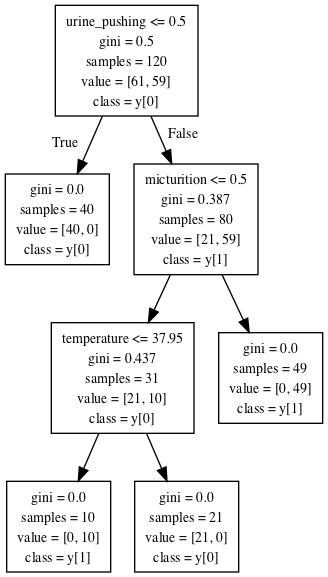

In [70]:
# 1B / Decision 1 Inflammation of urinary bladder { 1, 0 }

dtree1 = DecisionTreeClassifier()
dtree1.fit(df,y1)

dot_data1 = export_graphviz(dtree1, out_file=None, feature_names=columns, class_names=True)

tree1 = pydotplus.graph_from_dot_data(dot_data1)  
Image(tree1.create_png())

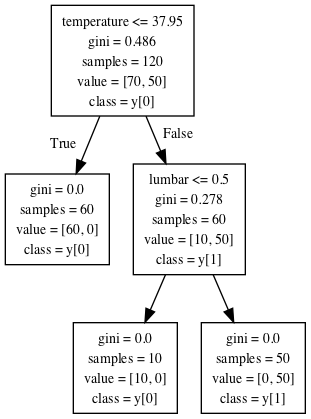

In [71]:
# 1B / Decision 2 Nephritis of renal pelvis origin { 1, 0 } 

dtree2 = DecisionTreeClassifier()
dtree2.fit(df,y2)

dot_data2 = export_graphviz(dtree2, out_file=None, feature_names=columns, class_names=True)

tree2 = pydotplus.graph_from_dot_data(dot_data2)  
Image(tree2.create_png())

In [75]:
# 1C

from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

features = ['temperature', 'nausea', 'lumbar', 'urine_pushing', 'micturition', 'urethra']
    
print('Decision 1 Tree')
tree_to_code(dtree1, features)

print()

print('Decision 2 Tree')
tree_to_code(dtree2, features)


Decision 1 Tree
def tree(temperature, nausea, lumbar, urine_pushing, micturition, urethra):
  if urine_pushing <= 0.5:
    return [[40.  0.]]
  else:  # if urine_pushing > 0.5
    if micturition <= 0.5:
      if temperature <= 37.95000076293945:
        return [[ 0. 10.]]
      else:  # if temperature > 37.95000076293945
        return [[21.  0.]]
    else:  # if micturition > 0.5
      return [[ 0. 49.]]

Decision 2 Tree
def tree(temperature, nausea, lumbar, urine_pushing, micturition, urethra):
  if temperature <= 37.95000076293945:
    return [[60.  0.]]
  else:  # if temperature > 37.95000076293945
    if lumbar <= 0.5:
      return [[10.  0.]]
    else:  # if lumbar > 0.5
      return [[ 0. 50.]]


In [2]:
# 2A

data_path = '../data/communities.data'

data = pd.read_csv(data_path, names = list(range(0, 128)), na_values=["?"])
data.drop(data.iloc[:, 0:5], inplace = True, axis = 1) 
data.reset_index()
#data = data.replace(to_replace='?', value = np.nan)
data.head()

5     6     7     8     9     10    11    12    13    14   ...    118  \
0  0.19  0.33  0.02  0.90  0.12  0.17  0.34  0.47  0.29  0.32  ...   0.12   
1  0.00  0.16  0.12  0.74  0.45  0.07  0.26  0.59  0.35  0.27  ...   0.02   
2  0.00  0.42  0.49  0.56  0.17  0.04  0.39  0.47  0.28  0.32  ...   0.01   
3  0.04  0.77  1.00  0.08  0.12  0.10  0.51  0.50  0.34  0.21  ...   0.02   
4  0.01  0.55  0.02  0.95  0.09  0.05  0.38  0.38  0.23  0.36  ...   0.04   

    119   120   121   122  123  124   125   126   127  
0  0.26  0.20  0.06  0.04  0.9  0.5  0.32  0.14  0.20  
1  0.12  0.45   NaN   NaN  NaN  NaN  0.00   NaN  0.67  
2  0.21  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.43  
3  0.39  0.28   NaN   NaN  NaN  NaN  0.00   NaN  0.12  
4  0.09  0.02   NaN   NaN  NaN  NaN  0.00   NaN  0.03  

[5 rows x 123 columns]

In [5]:
# 2B
data.fillna(data.mean(), inplace = True)
data.head()

train = data.head(1495)
y_train = train.pop(127)
x_train = train

test = data.drop(train.index.values)
y_test = test.pop(127)
x_test = test

In [209]:
# 2C

corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [6]:
# 2D

cvs = []
data.head(5)

for column in data:
    col = data.loc[:,column]
    cvs.append(np.std(col)/np.mean(col))

df = pd.DataFrame(cvs, columns = ['CV'], index = list(range(5, 128)))
df = df.sort_values(by = ['CV'], ascending = False)
print(df)


           CV
95   4.406597
94   3.484607
54   2.993446
56   2.899770
125  2.554625
32   2.304392
5    2.202950
15   2.001242
76   1.958288
118  1.677611
10   1.613873
66   1.458701
120  1.416317
7    1.410567
9    1.358821
61   1.299774
62   1.297306
64   1.283712
63   1.280912
73   1.126917
96   1.072022
79   1.064475
127  0.978769
55   0.919572
82   0.917981
85   0.878529
86   0.874514
119  0.871968
83   0.848531
84   0.847668
..        ...
98   0.338859
78   0.337456
126  0.337196
52   0.336164
97   0.335490
53   0.332639
49   0.332393
48   0.330528
50   0.329343
51   0.328469
18   0.327628
8    0.323700
99   0.320025
70   0.319327
47   0.316875
106  0.305485
100  0.304163
117  0.296109
102  0.293693
108  0.293675
12   0.290620
65   0.288601
77   0.269579
104  0.251355
107  0.229149
116  0.145919
109  0.131384
123  0.122301
110  0.121629
103  0.057112

[123 rows x 1 columns]


In [7]:
# 2E

df = df.head(11)

print('Top sqrt(123) CVs')
print()
print(df)

Top sqrt(123) CVs

           CV
95   4.406597
94   3.484607
54   2.993446
56   2.899770
125  2.554625
32   2.304392
5    2.202950
15   2.001242
76   1.958288
118  1.677611
10   1.613873


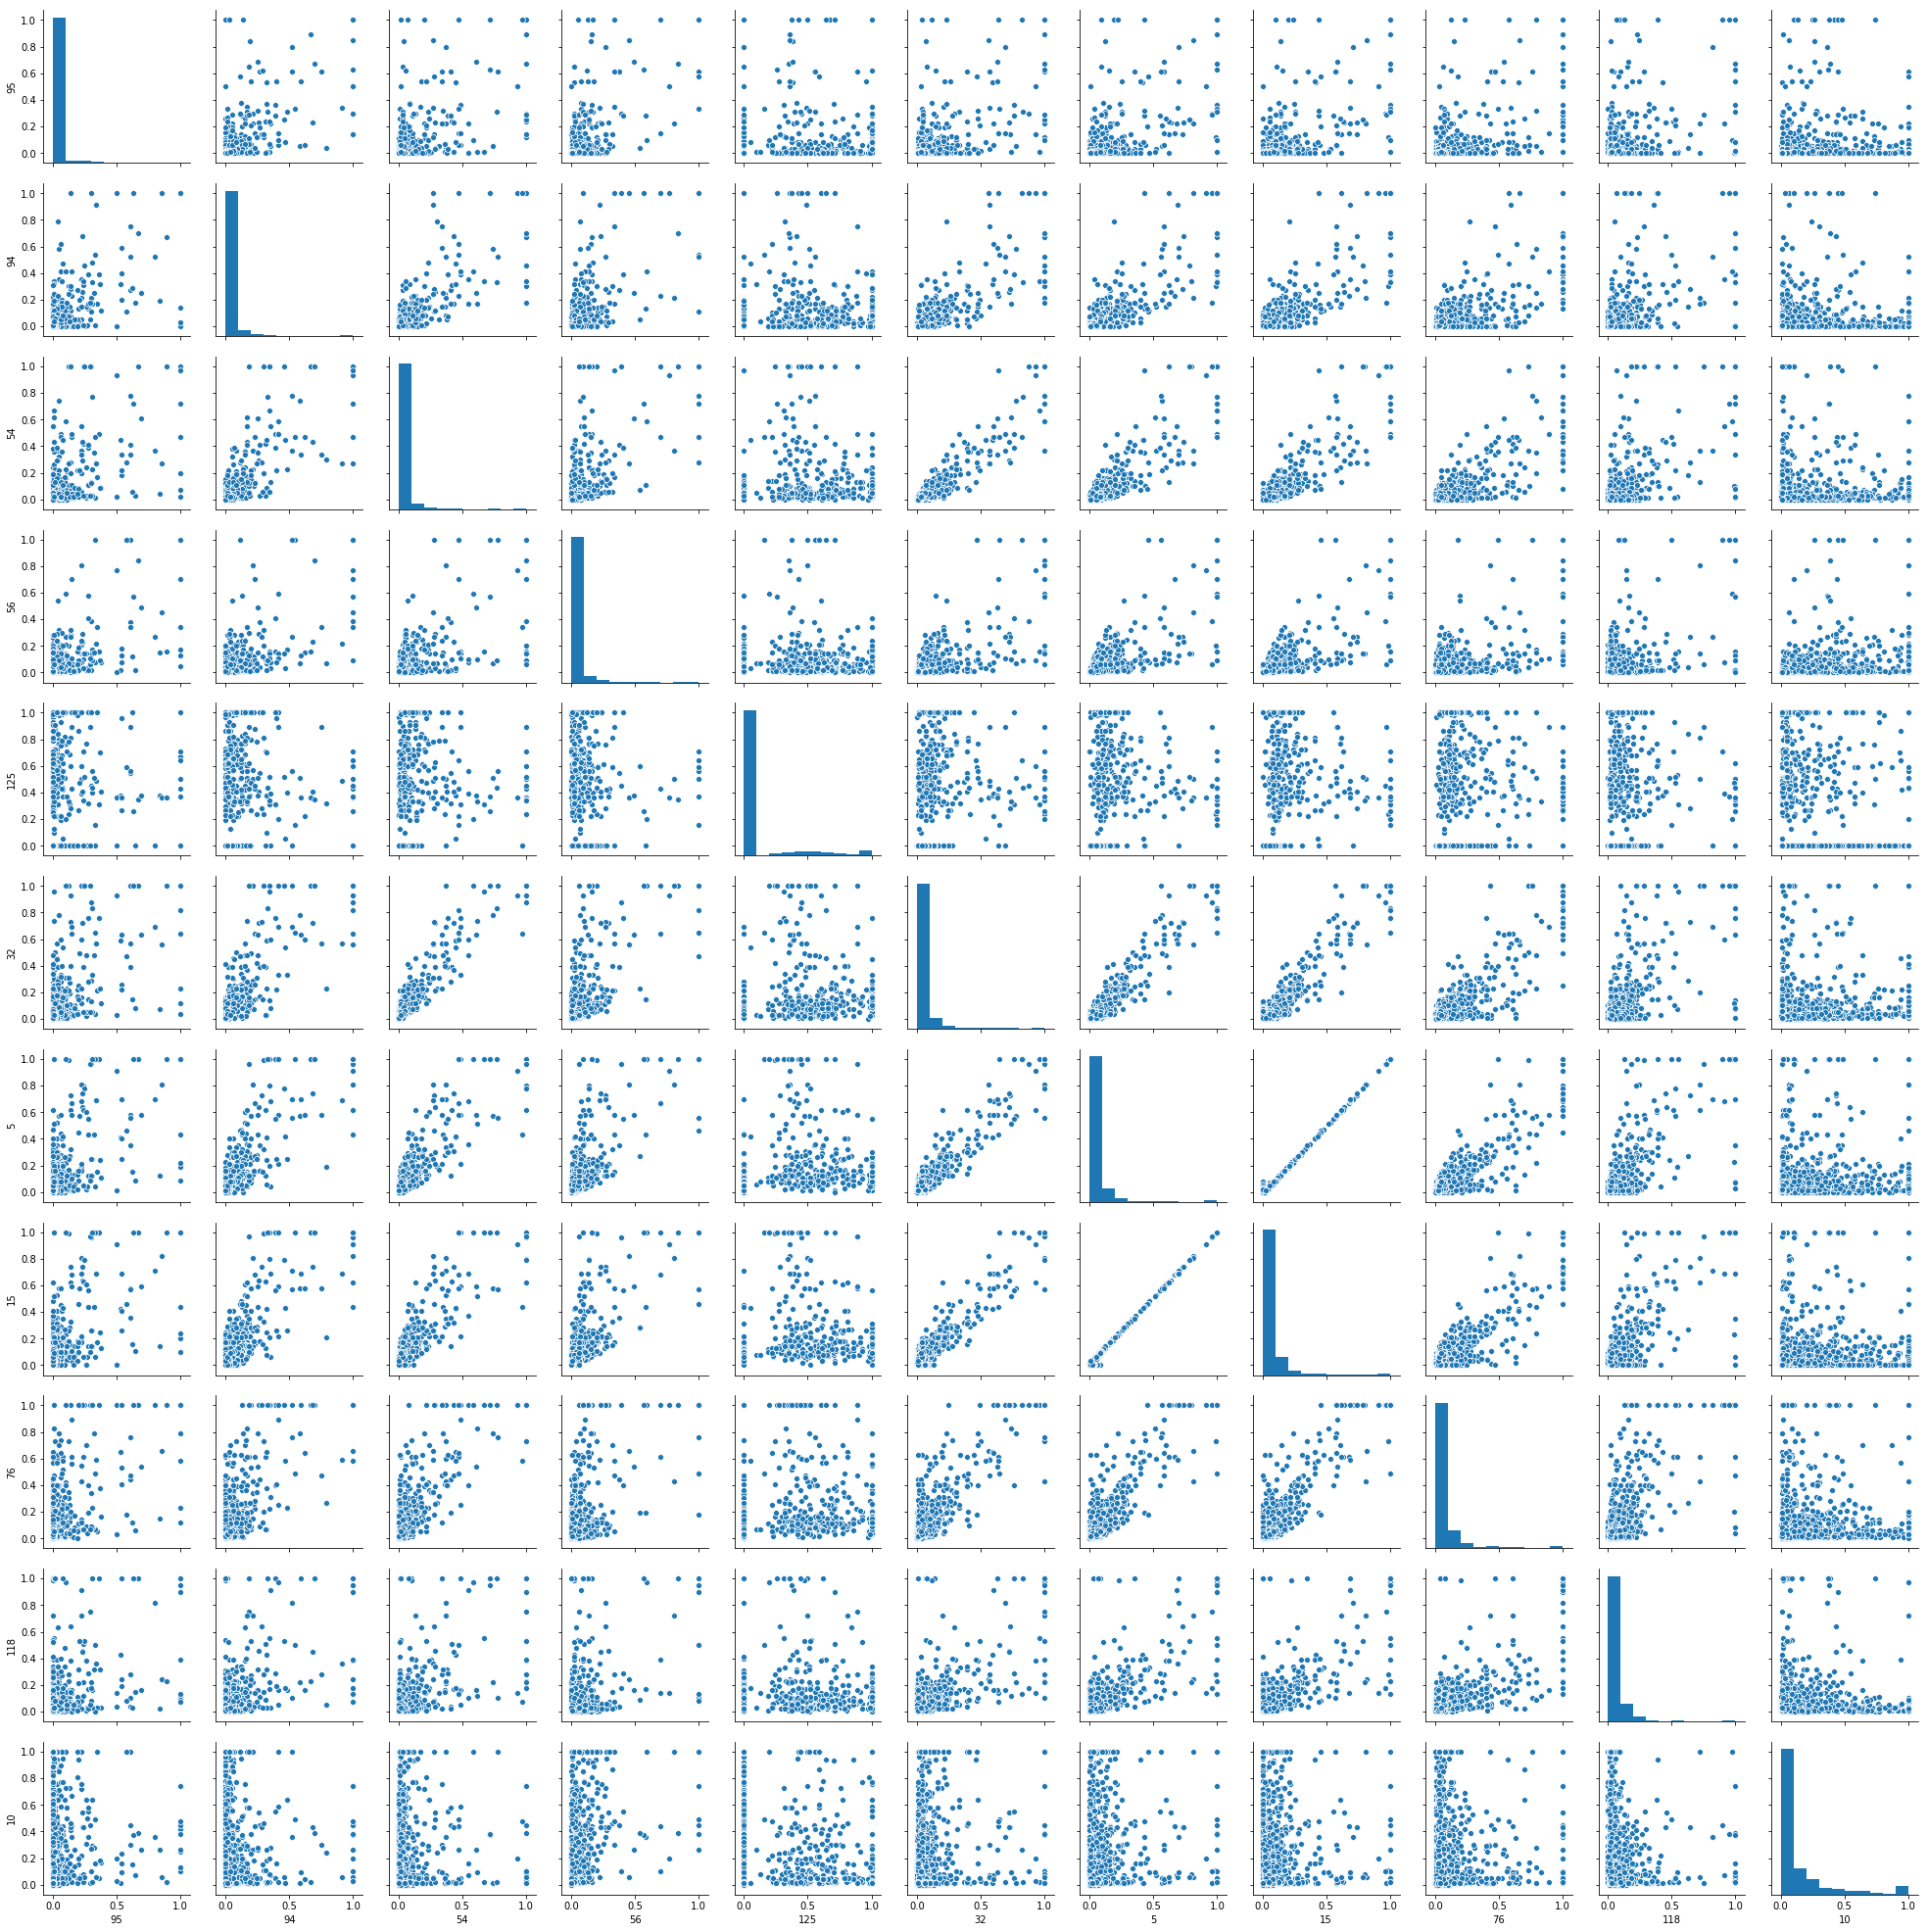

In [234]:
# 2E

highestCV = df.index.values

sb.pairplot(data[highestCV])

In [251]:
# 2F

regr = LinearRegression()
regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)
error = regr.score(x_train, y_train)

print('Linear Regression Error: ', 1 - error)

Error:  0.28814526585712263


In [254]:
# 2G

rr = RidgeCV(cv=5)
rr.fit(x_train, y_train)

error = rr.score(x_test, y_test)
print('Ridge CV Error: ', 1 - error)

Error:  0.3729780042930628


In [ ]:
# 2H

lr = LassoCV(cv=5)
lr.fit(x_train, y_train)

error = lr.score(x_test, y_test)
print('Lasso CV Error: ', 1 - error)

normalized_data=(data-data.mean())/data.std()

train_norm = normalized_data.head(1495)
y_train_norm = train_norm.pop(127)
x_train_norm = train_norm

test_norm = data.drop(train.index.values)
y_test_norm = test_norm.pop(127)
x_test_norm = test_norm

lr_norm = LassoCV(cv=5)
lr_norm.fit(x_train_norm, y_train_norm)

error_norm = lr.score(x_test_norm, y_test_norm)
print('Lasso CV Error (Normalized Data): ', 1 - error_norm)

In [16]:
# 2I / J

rfr = RandomForestRegressor(warm_start = True)
n_estimators = 20
error_rate = []

for i in range(1, n_estimators + 1):
    rfr.set_params(n_estimators=i)
    rfr.fit(x_train, y_train)
    oob_error = 1 - rfr.oob_score_
    error_rate.append((i, oob_error))

AttributeError: 'RandomForestRegressor' object has no attribute 'oob_score_'